
=== Starting PSO Feature Selection with Feature Minimization ===
Dataset dimensions: (125972, 42)
Parameters: num_particles=10, max_iter=20, alpha=0.99

Initial state:
Best score: 0.9952
Pure accuracy: 0.9997
Selected features: 19 (45.2%)

--- Iteration 1/20 ---

Iteration 1 Summary:
Best Score: 0.9952
Best Pure Accuracy: 0.9997
Selected Features: 19 (45.2%)
Mean Score: 0.9931
Mean Accuracy: 0.9989

--- Iteration 2/20 ---

Iteration 2 Summary:
Best Score: 0.9952
Best Pure Accuracy: 0.9997
Selected Features: 19 (45.2%)
Mean Score: 0.9941
Mean Accuracy: 0.9992

--- Iteration 3/20 ---

Iteration 3 Summary:
Best Score: 0.9952
Best Pure Accuracy: 0.9997
Selected Features: 19 (45.2%)
Mean Score: 0.9933
Mean Accuracy: 0.9982

--- Iteration 4/20 ---

Iteration 4 Summary:
Best Score: 0.9952
Best Pure Accuracy: 0.9997
Selected Features: 19 (45.2%)
Mean Score: 0.9922
Mean Accuracy: 0.9973

--- Iteration 5/20 ---

Iteration 5 Summary:
Best Score: 0.9952
Best Pure Accuracy: 0.9997
Selected Feature

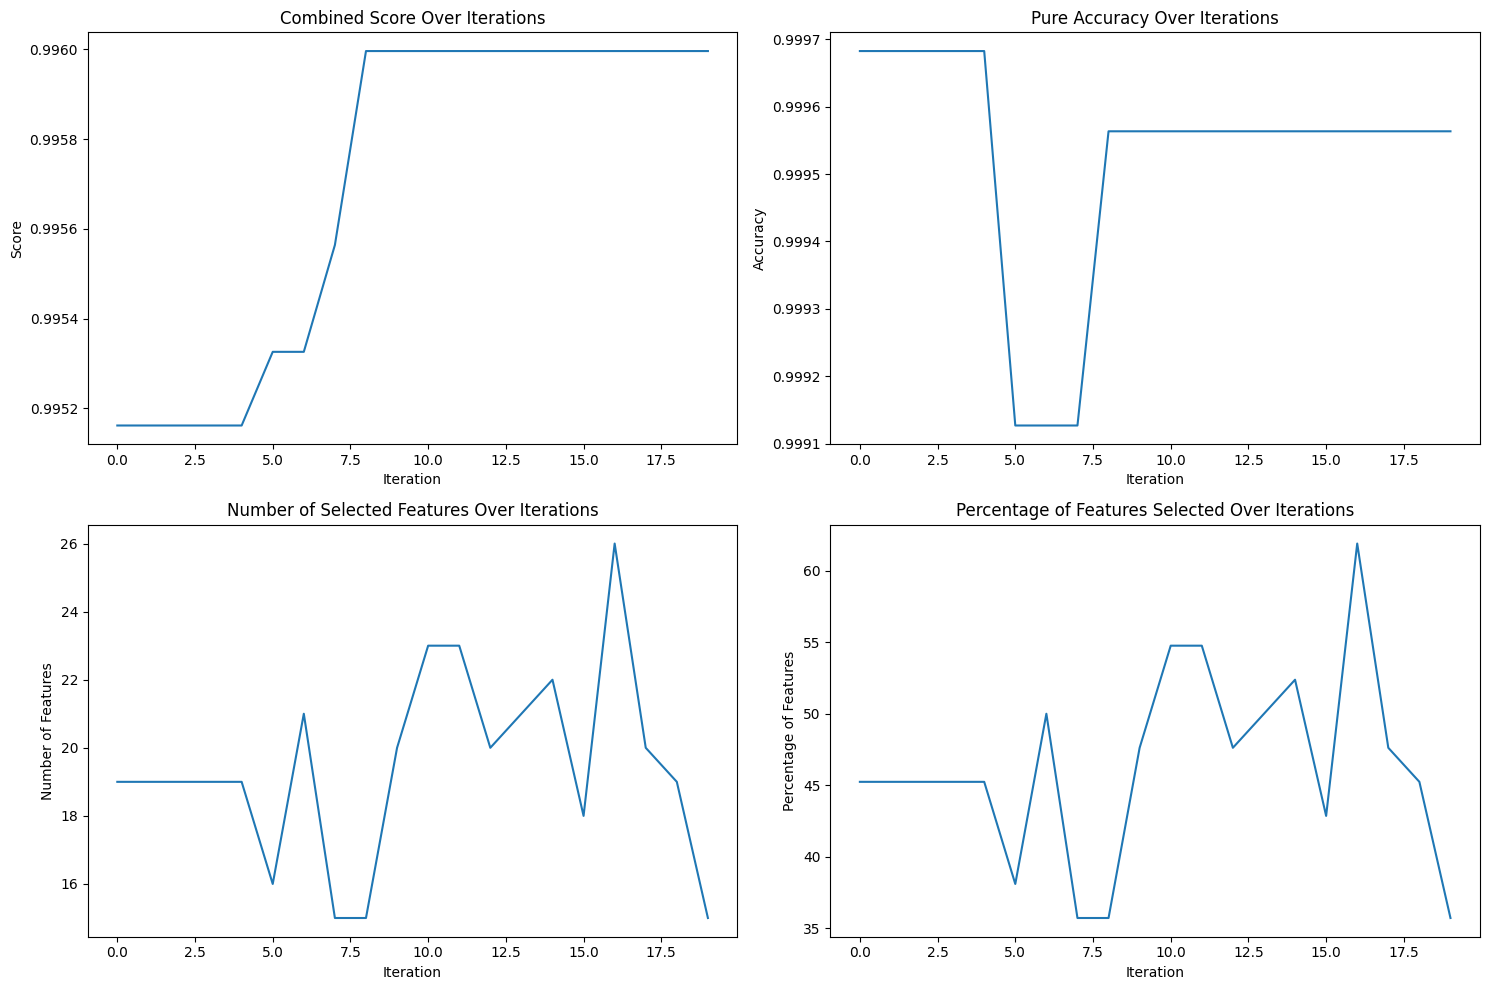

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


class PSOFeatureSelector:
    def __init__(self, X, y, num_particles=10, max_iter=20, alpha=0.99):
        self.X = X
        self.y = y
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.num_features = X.shape[1]
        self.global_best_position = np.random.randint(2, size=self.num_features)
        self.global_best_score = 0
        self.alpha = alpha  # Weight for accuracy vs feature count trade-off

        self.history = {
            'global_best_scores': [],
            'mean_particle_scores': [],
            'selected_feature_counts': [],
            'pure_accuracy_scores': []  # Track accuracy without penalty
        }

    def fitness(self, features):
        if np.sum(features) == 0:
            return 0

        selected_features = self.X.iloc[:, features.astype(bool)]
        X_train, X_test, y_train, y_test = train_test_split(selected_features, self.y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)

        # Feature count penalty term
        feature_ratio = np.sum(features) / self.num_features
        penalty = (1 - feature_ratio)  # Higher when fewer features are selected

        # Combined score: alpha * accuracy + (1-alpha) * penalty
        score = self.alpha * accuracy + (1 - self.alpha) * penalty

        return score, accuracy  # Return both combined score and pure accuracy

    def optimize(self):
        print("\n=== Starting PSO Feature Selection with Feature Minimization ===")
        print(f"Dataset dimensions: {self.X.shape}")
        print(f"Parameters: num_particles={self.num_particles}, max_iter={self.max_iter}, alpha={self.alpha}")

        particles = np.random.randint(2, size=(self.num_particles, self.num_features))
        velocities = np.random.rand(self.num_particles, self.num_features)
        personal_best_positions = np.copy(particles)

        # Initialize personal bests with both score and accuracy
        personal_best_scores = []
        personal_best_accuracies = []
        for p in particles:
            score, accuracy = self.fitness(p)
            personal_best_scores.append(score)
            personal_best_accuracies.append(accuracy)

        personal_best_scores = np.array(personal_best_scores)
        personal_best_accuracies = np.array(personal_best_accuracies)

        # Initialize global best
        best_idx = np.argmax(personal_best_scores)
        self.global_best_position = personal_best_positions[best_idx]
        self.global_best_score = personal_best_scores[best_idx]
        self.global_best_accuracy = personal_best_accuracies[best_idx]

        print(f"\nInitial state:")
        print(f"Best score: {self.global_best_score:.4f}")
        print(f"Pure accuracy: {self.global_best_accuracy:.4f}")
        print(
            f"Selected features: {np.sum(self.global_best_position)} ({np.sum(self.global_best_position) / self.num_features * 100:.1f}%)")

        for iteration in range(self.max_iter):
            print(f"\n--- Iteration {iteration + 1}/{self.max_iter} ---")

            iteration_scores = []
            iteration_accuracies = []

            for i in range(self.num_particles):
                # Update particle
                inertia = velocities[i] * 0.5
                cognitive = np.random.rand(self.num_features) * (personal_best_positions[i] - particles[i])
                social = np.random.rand(self.num_features) * (self.global_best_position - particles[i])
                velocities[i] = inertia + cognitive + social
                particles[i] = np.where(np.random.rand(self.num_features) < 1 / (1 + np.exp(-velocities[i])), 1, 0)

                # Evaluate particle
                score, accuracy = self.fitness(particles[i])
                iteration_scores.append(score)
                iteration_accuracies.append(accuracy)

                # Update personal best
                if score > personal_best_scores[i]:
                    personal_best_scores[i] = score
                    personal_best_accuracies[i] = accuracy
                    personal_best_positions[i] = particles[i]

                # Update global best
                if score > self.global_best_score:
                    old_features = np.sum(self.global_best_position)
                    new_features = np.sum(particles[i])

                    self.global_best_score = score
                    self.global_best_accuracy = accuracy
                    self.global_best_position = particles[i]

                    print(f"\nNew best solution found:")
                    print(f"Score: {score:.4f}")
                    print(f"Pure accuracy: {accuracy:.4f}")
                    print(f"Features: {new_features} ({new_features / self.num_features * 100:.1f}%)")
                    print(f"Change in features: {old_features} -> {new_features}")

            # Record iteration statistics
            mean_score = np.mean(iteration_scores)
            mean_accuracy = np.mean(iteration_accuracies)
            selected_features_count = np.sum(self.global_best_position)

            self.history['global_best_scores'].append(self.global_best_score)
            self.history['mean_particle_scores'].append(mean_score)
            self.history['selected_feature_counts'].append(selected_features_count)
            self.history['pure_accuracy_scores'].append(self.global_best_accuracy)

            print(f"\nIteration {iteration + 1} Summary:")
            print(f"Best Score: {self.global_best_score:.4f}")
            print(f"Best Pure Accuracy: {self.global_best_accuracy:.4f}")
            print(
                f"Selected Features: {selected_features_count} ({selected_features_count / self.num_features * 100:.1f}%)")
            print(f"Mean Score: {mean_score:.4f}")
            print(f"Mean Accuracy: {mean_accuracy:.4f}")

        print("\n=== PSO Feature Selection Completed ===")
        print(f"Final Best Score: {self.global_best_score:.4f}")
        print(f"Final Pure Accuracy: {self.global_best_accuracy:.4f}")
        print(
            f"Final Selected Features: {selected_features_count} ({selected_features_count / self.num_features * 100:.1f}%)")

        return self.global_best_position, self.global_best_score, self.global_best_accuracy, self.history


# Example usage
if __name__ == "__main__":
    df = pd.read_csv("../data/BinaryClassify/train_nsl_kdd_binary_encoded.csv")
    X = df.drop(columns=["binaryoutcome"])
    y = df["binaryoutcome"]

    pso_selector = PSOFeatureSelector(X, y, alpha=0.99)  # Adjust alpha to control accuracy vs feature count trade-off
    best_features, best_score, best_accuracy, history = pso_selector.optimize()
    selected_feature_names = X.columns[best_features.astype(bool)]

    print("\nDetailed Final Results:")
    print(f"Number of features selected: {len(selected_feature_names)} out of {X.shape[1]}")
    print(f"Feature reduction: {(1 - len(selected_feature_names) / X.shape[1]) * 100:.1f}%")
    print(f"Pure accuracy: {best_accuracy:.4f}")
    print(f"Combined score: {best_score:.4f}")
    print("\nSelected features:", list(selected_feature_names))

    # Visualization
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history['global_best_scores'])
    plt.title('Combined Score Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Score')

    plt.subplot(2, 2, 2)
    plt.plot(history['pure_accuracy_scores'])
    plt.title('Pure Accuracy Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(history['selected_feature_counts'])
    plt.title('Number of Selected Features Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Features')

    plt.subplot(2, 2, 4)
    feature_percentages = [count / X.shape[1] * 100 for count in history['selected_feature_counts']]
    plt.plot(feature_percentages)
    plt.title('Percentage of Features Selected Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Percentage of Features')

    plt.tight_layout()
    plt.show()